# Assignment 3

In [89]:
!pip install opencv-contrib-python==3.4.2.16
!pip install matplotlib==3.1.1

In [90]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

# Verifica versione di OpenCV
print(cv.__version__)

3.4.2


In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
images = "/content/drive/My Drive/Digital Signal and Image Management/Esercitazioni/Esercitazione 4/images/"

In [0]:
# Imposta le dimensioni di visualizzazione nel notebook
plt.rcParams['figure.figsize'] = [15, 5] # width, height

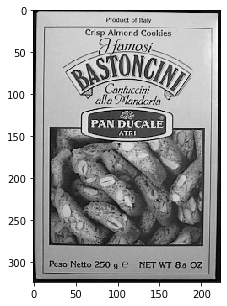

In [94]:
# Caricamento immagine
box = cv.imread(images + 'box.png',0)
plt.imshow(box, cmap='gray'); plt.show()

# Detection e descrizione SIFT

https://docs.opencv.org/3.4.2/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677

In [0]:
# Detection e descrizione SIFT
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(box, None)

In [96]:
# Numero di keypoint rilevati
len(kps1)

604

In [97]:
# Descrittori corrispondenti
features1.shape

(604, 128)

In [98]:
# Informazioni disponibili per ciascun keypoint
print(type(kps1[0]))
print(dir(kps1[0]))

<class 'cv2.KeyPoint'>
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size']


A ciascun keypoint sono associati:
* Un descrittore a 128 dimensioni (nella variabile ``features``)
* Una serie di proprietà (accessibili direttamente dal keypoint):
    * angle
    * class_id
    * octave
    * pt
    * response
    * size


In [99]:
# Esempio: coordinate del primo keypoint
kps1[0].pt

(3.161376476287842, 204.0614776611328)

### Visualizzazione keypoint

https://docs.opencv.org/3.4.2/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433

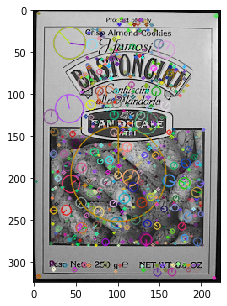

In [100]:
# Visualizzazione punti SIFT
box_kps = cv.drawKeypoints(box, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(box_kps); plt.show()

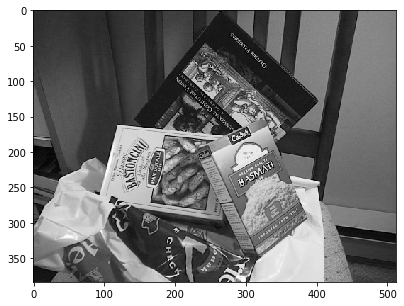

In [101]:
# Caricamento immagine background
scene = cv.imread(images + 'box_in_scene.png',0)
plt.imshow(scene, cmap='gray'); plt.show()

In [0]:
# Detection e descrizione SIFT sulla seconda immagine
(kps2, features2) = sift.detectAndCompute(scene, None)

# Matching

https://docs.opencv.org/3.4.2/dc/dc3/tutorial_py_matcher.html

In [0]:
# Rilevamento corrispondenze features tra le due immagini
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [104]:
# Numero di match tra le due immagini
len(matches)

398

In [105]:
# Informazioni associate a ciascun match
print(type(matches[0]))
print(dir(matches[0]))

<class 'cv2.DMatch'>
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']


Ciascun match contiene le seguente informazioni:
* distance
* imgIdx
* queryIdx
* trainIdx

In [0]:
# Esempio: dettagli sul primo match.

In [107]:
# Indice keypoint della prima immagine (box)
matches[0].queryIdx

0

In [108]:
# Indice keypoint della seconda immagine (scene)
matches[0].trainIdx

881

### Visualizzazione match

https://docs.opencv.org/3.4.2/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1

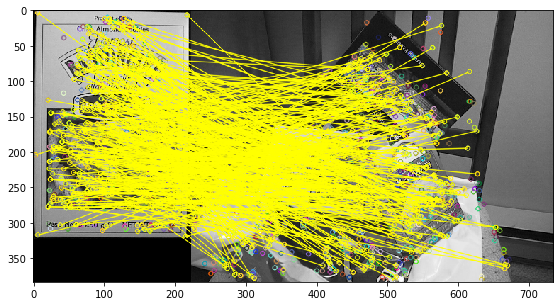

In [109]:
# Visualizzazione match
result = cv.drawMatches(box, kps1, scene, kps2, matches, None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

**Nota:**

L'insieme dei match contiene molti falsi positivi.

Una possibilità è ordinare i match a partire dai più sicuri (quelli con descrittori molto simili, ovvero con distanza bassa),<br/>
e limitare la visualizzazione ai primi N

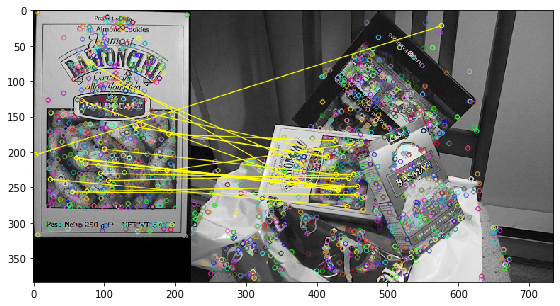

In [110]:
# Visualizzazione match filtrati
matches = sorted(matches, key=lambda x:x.distance)
result = cv.drawMatches(box, kps1, scene, kps2, matches[0:20], None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

# Photo stitching - Assignment

### Caricamento immagini

In [0]:
im1 = cv.imread(images + 'boat1.jpg',0)
im2 = cv.imread(images + 'boat3.jpg',0)

### Estrazione keypoint

In [0]:
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Match features
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

### 1. Trovare l'omografia che descrive la trasformazione tra il <u>secondo</u> set di punti ed il <u>primo</u>

https://docs.opencv.org/3.4.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780

Definisco la funzione myhomography che forniti in input i punti descrittivi delle due immagini e i relativi match restituisce l'omografia

In [0]:
def myhomography(kps1, kps2, matches):
    p1 = np.zeros((len(matches), 2))#, dtype=np.float32)
    p2 = np.zeros((len(matches), 2))#, dtype=np.float32)
    for elem, match in enumerate(matches):
        p1[elem, :] = kps1[match.queryIdx].pt
        p2[elem, :] = kps2[match.trainIdx].pt
    H, mask = cv.findHomography(p2, p1, cv.RANSAC)
    return H

In [0]:
H = myhomography(kps1, kps2, matches)

Si mostra il contenuto dell'omografia appena trovata

In [115]:
print(H)

[[ 5.70083154e-01 -2.20799284e-02  5.21896657e+02]
 [-1.51066884e-01  9.11596153e-01  3.06053901e+01]
 [-5.44265695e-04 -3.47411518e-05  1.00000000e+00]]


### 2. Applicare l'omografia alla seconda immagine

https://docs.opencv.org/3.4.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87

https://docs.opencv.org/3.4.2/da/d6e/tutorial_py_geometric_transformations.html

Definisco la funzione myWarp che prese in input due immagini e una omografia produce la base per il collage, tale per cui l'immagine che vi è presente all'interno è già orientata correttamente.
<br>Questa richiede i seguenti parametri:
<ol>
  <li>immagini di input</li>
  <li>omografia ottenuta dalle due immagini</li>
</ol>
Sfrutta la funzione cv.warpPerspective che prende in input una delle due immagini, l'omografia e necessita che si specifichi la dimensione del'immagine che si vuole ottenere (larghezza data delle due immagini sommate, altezza data dalla prima immagine)

### Funzione di Warp delle immagini
(deformo un immagine per poterla unire all'altra)

In [0]:
def myWarp(im1, im2, H):
  #come input la funzione warpPerspective richiede:
  # -immagine input
  # -omografia
  # -dimensione dell'immagine di output (larghezza delle due immagini sommate, altezza della prima immagine)
  return cv.warpPerspective(im2, H, (im1.shape[1] + im2.shape[1], im1.shape[0]))

Produco la base dello stitching

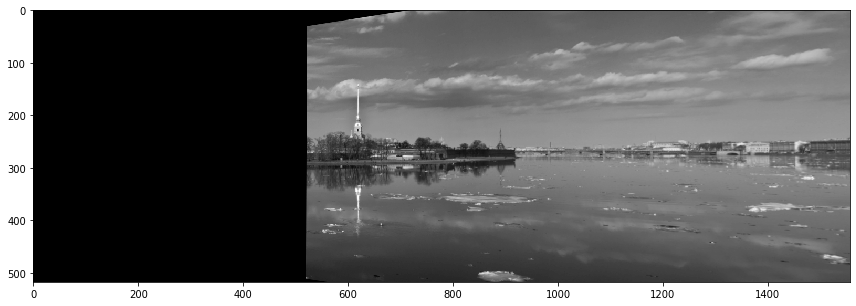

In [117]:
temp = myWarp(im1, im2, H)
plt.imshow(temp, cmap='gray'); plt.show()

### 3. Integrare la prima immagine

``im_base[from_y:to_y, from_x:to_x] = im_new``

### Funzione di Collage
Definisco la funzione per integrare all'interno della immagine ottenuta con la funzione myWarp quella necessaria per completare lo stitching

In [0]:
def myCollage(im_base, im_new):
  im_base[0:im_new.shape[0], 0:im_new.shape[1]] = im_new
  return im_base

Mostro le due fotografie separate

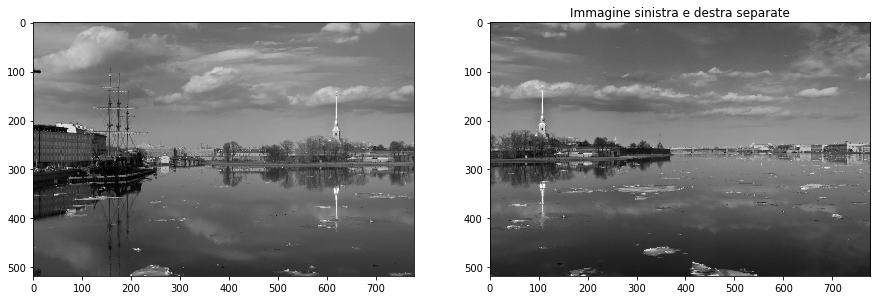

In [119]:
plt.subplot(1, 2, 1)
#plt.plot(t, s, '-', lw=2)
plt.imshow(im1, cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(im2, cmap='gray');
plt.title("Immagine sinistra e destra separate")
plt.show()

Fotografia finale, risultato del collage

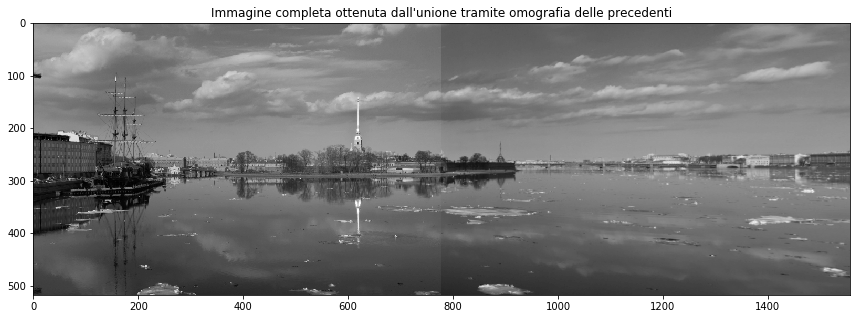

In [120]:
result = myCollage(temp, im1)
plt.imshow(result, cmap='gray'); 
plt.title("Immagine completa ottenuta dall'unione tramite omografia delle precedenti")
plt.show()